## Feature selection of pyradiomic feutures
 #### As refered in article 2 the most common algoritms for feuture selection are random forest, PCA(principle component analysis) and LASSO(least absolute shrinkage and selection operator) we'll be using all 3 and choosing the one that has the best results in several metrics

library imports + dataset handling comemt further

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

## 0 Data preparation

#### 0.0 Dataset loading and class normalization

As indicated by the professor its important to normalize the classes because if so isn't done its setting a preference to a class over another so we decide to normalize all the columns betwin 0 and 1. For the malignancy class we classified the cases were the malignancy is 1 or 2 as bennign and 4 or 5 as malignent and deleted all elements of malignancy 3 as they don't make sence to use in a binnary classifier  

In [2]:
dataset_path = r'Feature Extraction and Data Cleaning\radiomic_features_pylidc_and_fourier_per_annotation.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(dataset_path)
# Get the shape of the dataset (rows, columns)
print(df.shape)

# Get basic statistics about the dataset
print(df.describe())

# Classifying the malignancy
df['malignancy'] = df['malignancy'].replace({1: 0, 2: 0, 4: 1, 5: 1})  # 0 = benign, 1 = malignant
df = df[df['malignancy'] != 3]  # Removing rows with malignancy 3

# Drop Non-Numeric Columns
df_numeric = df.select_dtypes(include=[float, int])

# Separate Features and Target
X = df_numeric.drop('malignancy', axis=1)  # Features
y = df_numeric['malignancy']  # Target

# Normalize Features Between 0 and 1
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Create a New DataFrame
processed_df = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)



(6859, 153)
       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                      6859.000000                         6859.000000   
mean                       -540.352213                         -949.656655   
std                         158.899785                           71.932389   
min                        -895.726852                        -1403.000000   
25%                        -656.677452                        -1018.000000   
50%                        -554.944444                         -960.000000   
75%                        -442.556090                         -903.000000   
max                         359.254545                         -263.000000   

       diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
count                         6859.000000                         6859.000000   
mean                           318.691209                          867.871410   
std                            572.672501 

Due to the imbalence of the malign and benign class, as recomended by the professor we decided to apply some tecnics to balance the classes.
In the provided documents we dind't find references to either undersampling or oversampling so we went to https://imbalanced-learn.org/ to learn more about the different tecnics and we saw that common oversampling tecnics are SMOTE that generates new samples by interpolating existing ones and ADASYN that generates samples like smote but focuses more on missclassified minority class samples. We decided to use both to see the diference betwin the two tecnics, about oversampling we decided not to use it due to the fact that we would be deliting half the samples of the bennign class and there are hybrid models like SMOTEENN and SMOTETomek that combine both undersampling and oversampling so we decided to use SMOTETomek since betwin the 2 is the least agressive in terms of removing samples while still cleaning the daatset of noisy data and compared to undersampling tecnics it reduces less samples

#### 0.1 SMOTE

In [3]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled_, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_train_resampled and y_train_resampled are your balanced training sets

#### 0.2 ADASYN

In [4]:
adasyn = ADASYN(random_state=42)
X_train_resampled_adasyn, y_train_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

#### 0.3 SMOTETomek

In [5]:
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled_smote_tomek, y_train_resampled_smote_tomek = smote_tomek.fit_resample(X_train, y_train)


## 1 Feature selection

##### 1.1 Random forest

In [6]:
# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

rf.fit(X_train, y_train)

# Make predictions and calculate accuracy before feature selection
y_pred = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(initial_accuracy)


0.8683901292596945


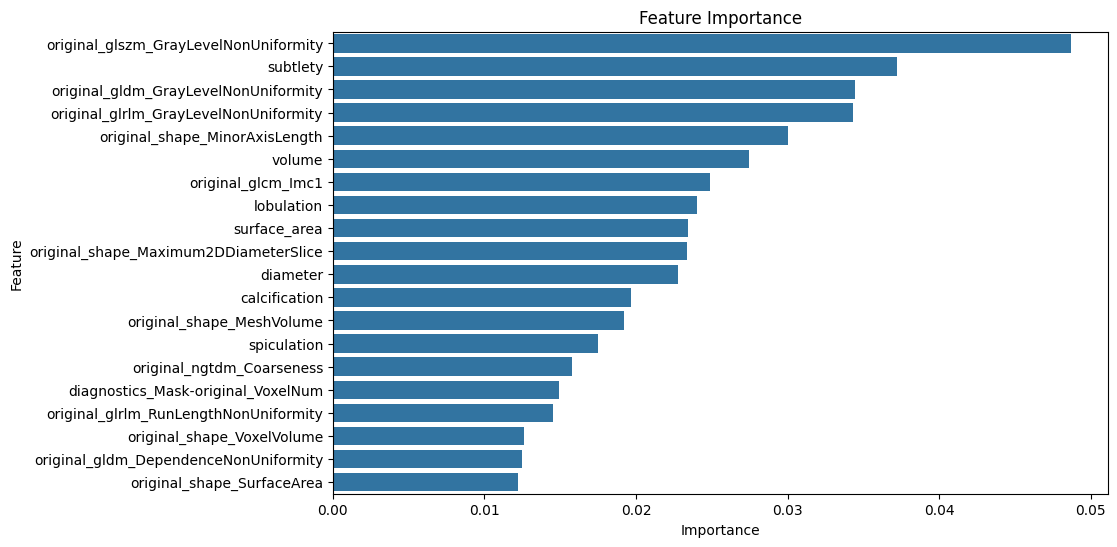

In [7]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df_small = feature_importance_df.head(20)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_small)
plt.title('Feature Importance')
plt.show()


In [8]:
# Select top 5 features (as an example)
top_features = feature_importance_df.head(40)['Feature'].values

# Create a new dataset with only the top features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


# Train the classifier with selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Make predictions and calculate accuracy after feature selection
y_pred_selected = rf_selected.predict(X_test_selected)
selected_accuracy = accuracy_score(y_test, y_pred_selected)

print(f'Accuracy before feature selection: {initial_accuracy:.4f}')
print(f'Accuracy after feature selection: {selected_accuracy:.4f}')


Accuracy before feature selection: 0.8684
Accuracy after feature selection: 0.8884


#### 1.2 LASSO

In [9]:
# Convert the continuous target into binary labels (benign/malignant)
threshold = 0.5  # Assuming values >= 0.5 are malignant
y_binary = np.where(y >= threshold, 1, 0)  # 1 for malignant, 0 for benign

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


# Standardize the features (important for LASSO)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model with L1 (LASSO) regularization
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
lasso.fit(X_train_scaled, y_train)

# Get the coefficients
coefficients = lasso.coef_

# Find the indices of the non-zero coefficients
non_zero_features = np.where(coefficients != 0)[1]
non_zero_features = np.unique(non_zero_features)
# Print the selected features
print("Selected features:", non_zero_features)

# You can map back these indices to the original feature names if needed
selected_feature_names = X.columns[non_zero_features]
print("Selected feature names:", selected_feature_names)

Selected features: [  0   1   2   4   5   6   8  11  12  14  15  16  17  18  20  21  22  23
  24  26  29  30  32  33  34  35  39  40  46  47  48  49  50  51  54  56
  57  59  61  63  64  65  69  70  71  73  80  83  84  87  92  95  97  98
 101 103 106 107 108 109 111 112 113 114 115 116 117 118 119 120 121 122
 123 125 126 127 128 129 130 131]
Selected feature names: Index(['diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_VolumeNum', 'original_shape_Elongation',
       'original_shape_Flatness', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MinorAxisLength',
       'original_shape_Sphericity', 'original_shape_SurfaceArea',
       'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume',
       'original_firstorder_90Percentile', 'original_firstorder_Energy',
       'original_firstord

#### 1.3 PCA

In [10]:
# Step 1: Standardize the data
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA(n_components=X.shape[1])  # Fit PCA to all features
X_pca = pca.fit_transform(X_scaled)

# Step 3: Create a DataFrame with feature importance
pca_df = pd.DataFrame(pca.components_, columns=X.columns)

# Step 4: Calculate the absolute value of the feature weights
feature_importance = np.abs(pca_df).sum(axis=0)

# Step 5: Create a DataFrame to see feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 6: Print the feature importance
print("Feature Importance:")
print(feature_importance_df)

# Optional: Select top N features
N = 10  # Change this to the number of top features you want
top_features = feature_importance_df.head(N)
print(f"\nTop {N} features based on PCA:")
print(top_features)

Feature Importance:
                                                                     Feature  \
original_glrlm_GrayLevelNonUniformity  original_glrlm_GrayLevelNonUniformity   
original_glcm_Idmn                                        original_glcm_Idmn   
original_glcm_Contrast                                original_glcm_Contrast   
original_gldm_DependenceVariance            original_gldm_DependenceVariance   
original_firstorder_Minimum                      original_firstorder_Minimum   
...                                                                      ...   
fourier_hist_bin_4                                        fourier_hist_bin_4   
fourier_hist_bin_7                                        fourier_hist_bin_7   
fourier_hist_bin_5                                        fourier_hist_bin_5   
fourier_hist_bin_0                                        fourier_hist_bin_0   
internalStructure                                          internalStructure   

                   

## 2 Classifiction models

#### 2.1 Logistic regression

#### 2.2 Random forest

#### 2.3 Svm

## 3 Performance comparation